In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath

In [2]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/PSM3/current_state', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnosti

In [3]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

# while left_image is None or right_image is None:
#     print("left or right image not receieved")
#     time.sleep(0.5)

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnU3RvcCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCkpLCBPdXRwdXQobGF5b3V0PUxheW91dChib3JkZXLigKY=


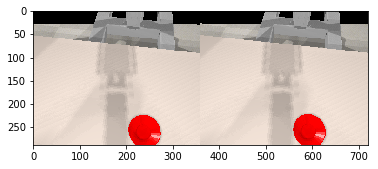

In [4]:
time.sleep(1)
plt.imshow(np.hstack((left_image, right_image)))

In [5]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 1234
  stamp: 
    secs: 1620094734
    nsecs: 953627110
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 1234
  stamp: 
    secs: 1620094734
    nsecs: 953627110
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  

In [6]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, psm2, psm3, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    psm2 = dvrk.psm('PSM2')
    psm3 = dvrk.psm('PSM3')
    
    psm1_suj = dvrk.suj('PSM1')
    psm2_suj = dvrk.suj('PSM2')
    psm3_suj = dvrk.suj('PSM3')
    ecm_suj = dvrk.suj('ECM')
    
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [7]:
tf_listener = tf.TransformListener()
time.sleep(5)

In [8]:
tf_listener.getFrameStrings()

/home/iandre/dvrk_ws/src/geometry/tf/src/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['ecm_roll_link',
 'PSM2_tool_wrist_shaft_link',
 'PSM3_clip',
 'PSM2_outer_pitch_front_link',
 'PSM1_RCM',
 'PSM2_tool_main_link',
 'PSM2_tool_wrist_caudier_link_2_left',
 'PSM1',
 'PSM2',
 'PSM3',
 'PSM2_tool_wrist_caudier_ee_link',
 'PSM1_tool_wrist_sca_ee_link_1',
 'PSM1_tool_wrist_sca_ee_link_2',
 'ecm_setup_link',
 'ECM_RCM',
 'ecm_yaw_link',
 'PSM2_tool_wrist_caudier_link_shaft',
 'PSM1_tool_wrist_sca_ee_link_0',
 'ECM',
 'PSM1_outer_pitch_link',
 'PSM2_base',
 'PSM2_outer_pitch_link',
 'camera',
 'PSM1_outer_pitch_front_link',
 'ecm_pitch_link',
 'PSM1_outer_pitch_top_link',
 'PSM2_RCM',
 'PSM2_tool_wrist_caudier_link',
 'PSM1_outer_yaw_link',
 'ecm_pitch_link_1',
 'ecm_pitch_link_2',
 'ecm_pitch_link_3',
 'PSM1_tool_wrist_shaft_link',
 'PSM2_outer_pitch_back_link',
 'PSM1_tool_wrist_sca_link',
 'PSM2_outer_pitch_top_link',
 'PSM3_base',
 'PSM2_tool_wrist_caudier_ee_link_0',
 'PSM1_outer_insertion_link',
 'PSM1_tool_tip_link',
 'ECM_base',
 'ecm_insertion_link',
 'Vision_sensor

In [9]:
from math import radians as r

# 2 arm setup
# sm1 = [0.5, -2.4958207607269287, 2.775073528289795, 0.13962633907794952, -0.5235987901687622]
# sm2 = [0.5, 2.6005406379699707, -2.7227137088775635, -0.20943951606750488, -0.7155849933624268]
# cm = [1.0, -1.2042771577835083, 2.687807083129883, -1.4311699867248535]

# 3 arm setup
# height, shoulder, elbow, wrist, rotate
sm1 = [0.0, -1.5, 1.8, 0.4, -0.9]  # right
sm2 = [0.0, 1.5, -1.8, -0.4, -0.9]  #  left
sm3 = [0.4, 2.1, -1.8, -1.0, -1.4]  # middle
cm = [0.52, 0.7, -1.6, 0.9]

psm1_suj.move_joint(np.asarray(sm1))
psm2_suj.move_joint(np.asarray(sm2))
psm3_suj.move_joint(np.asarray(sm3))
ecm_suj.move_joint(np.asarray(cm))

print(psm1_suj.get_current_joint_position())
print(psm2_suj.get_current_joint_position())
print(psm3_suj.get_current_joint_position())
print(ecm_suj.get_current_joint_position())
print('----------------------------------')
print(psm1_suj.get_current_position())
print(psm2_suj.get_current_position())
print(psm3_suj.get_current_position())
print(ecm_suj.get_current_position())

[ 0.08       -1.22173047  1.57079637  0.17453292  0.        ]
[ 0.08        1.22173047 -1.57079637 -0.17453292  0.        ]
[ 0.5         2.21656823 -1.4486233  -1.57079637 -1.01229095]
[ 0.60000002  0.78539819 -1.57079637  0.78539819]
----------------------------------
[[ 3.33067e-16,          -1,           0;
            1, 3.33067e-16,           0;
            0,           0,           1]
[     -1.9501,   -0.101602,      0.9088]]
[[ 3.33067e-16,           1,           0;
           -1, 3.33067e-16,          -0;
           -0,           0,           1]
[      1.9501,   -0.101598,      0.9088]]
[[           1,           0,           0;
            0,           1,           0;
            0,           0,           1]
[-1.50197e-06,      2.0009,      0.9163]]
[[          -1, 6.27081e-06, 2.59709e-06;
 -6.27081e-06,   -0.707176,   -0.707037;
 -2.59709e-06,   -0.707037,    0.707176]
[  3.6871e-06,    0.495318,    0.329477]]


In [10]:
# 3 arm setup
# ecm: rotate, up/down, zoom, rotate view
HARDCODED_ECM_POS = np.array([-0.4, -0.3, 0.15, 0.0])
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
# 2 arm setup
# HARDCODED_ECM_POS = np.array([0.0, 0.0, 0.0, 0.0])
# PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
time.sleep(5)

psm1.move_joint(deepcopy(PSM_HOME_POS))
psm1.close_jaw()
time.sleep(1)

psm2.move_joint(deepcopy(PSM_HOME_POS))
psm2.close_jaw()
time.sleep(1)

# psm3.move_joint(deepcopy(PSM_HOME_POS))
# psm3.close_jaw()
# time.sleep(1)

ecm.move_joint(HARDCODED_ECM_POS)

True

In [11]:
pick_and_place_utils = None
from pick_and_place_utils import get_objects_and_img, tf_to_pykdl_frame, PSM_J1_TO_BASE_LINK_TF, World
import image_geometry

time.sleep(1)
tf_cam_to_world = tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'Vision_sensor_left', rospy.Time()))

tf_world_to_psm1 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
tf_world_to_psm2 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))
# tf_world_to_psm3 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM3_base', 'simworld', rospy.Time()))

tf_world_to_psm1_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM1', 'world', rospy.Time()))
tf_world_to_psm1_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm1_j1

tf_world_to_psm2_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'world', rospy.Time()))
tf_world_to_psm2_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm2_j1

tf_cam_to_world

[[    0.069831,    0.967248,    0.244038;
     0.938257,   0.0194053,   -0.345394;
    -0.338818,    0.253089,   -0.906172]
[    -1.01633,   0.0254476,     1.22761]]

In [12]:
stereo_cam = image_geometry.StereoCameraModel()
stereo_cam.fromCameraInfo(left_camera_info, right_camera_info)

objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, 
                                          cam_to_world_tf=tf_cam_to_world)
world = World(objects)
world

<World objects: [<Object3d pos: [    -0.98296,   0.0023198,     1.03025] type: FeatureType.BALL color: 0>, <Object3d pos: [   -0.990197,  -0.0300298,     1.04063] type: FeatureType.BALL color: 2>, <Object3d pos: [    -1.01025,  -0.0979896,      1.0304] type: FeatureType.BALL color: 1>, <Object3d pos: [    -1.01344,  -0.0504044,     1.04214] type: FeatureType.BALL color: 2>, <Object3d pos: [    -1.02475, -0.00212014,     1.04459] type: FeatureType.BALL color: 0>, <Object3d pos: [    -1.03358,  -0.0695455,     1.04401] type: FeatureType.BALL color: 1>]
bowl: <Object3d pos: [    -0.89927,  -0.0435668,     1.03954] type: FeatureType.BOWL color: 0>>

In [13]:
len(objects)

7

[    -0.89927,  -0.0435668,     1.03954]


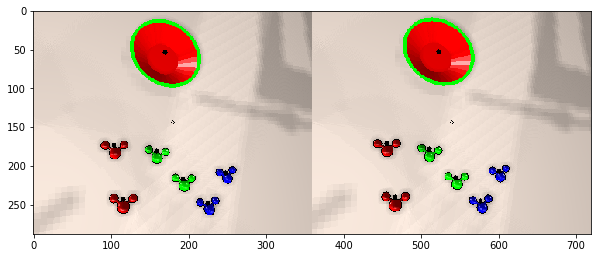

In [14]:
ball_pos_cam = objects[0].pos
print(ball_pos_cam)

plt.figure(figsize=(10, 5))
plt.imshow(frame)

In [15]:
from pick_and_place_arm_sm import PickAndPlaceStateMachine, PickAndPlaceState
from pick_and_place_hsm import PickAndPlaceHSM
from pick_and_place_dual_arm_sm import PickAndPlaceDualArmStateMachine
import IPython
from timeit import default_timer as timer
from pick_and_place_utils import get_objects_for_psms
from enum import Enum
the_image = IPython.display.Image(frame)

objects_to_pick = deepcopy(world.objects)

# this vector is empirically determined
# approach_vec = PyKDL.Vector(0.007, 0.0, -0.015)
approach_vec = PyKDL.Vector(0.000, 0.0, 0.0)

In [ ]:
start_time = time.time()

sm = PickAndPlaceStateMachine(psm1, world, tf_world_to_psm1_base, None, approach_vec, closed_loop=True)

while not (sm.is_done() or sm.state == PickAndPlaceState.HOME):
    objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
    world = World(objects)
    sm.update_world(world)
    sm.run_once()

In [17]:
completion_time = time.time()
print("Task took {} seconds".format(completion_time - start_time))

NameError: name 'start_time' is not defined

In [ ]:
time.sleep(1)
psm1.move_joint(np.asarray([0., 0., 0.08, 0., 0., 0.]))
psm2.move_joint(np.asarray([0., 0., 0.08, 0., 0., 0.]))

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(frame)

In [ ]:
time.time()